## Determination of Negative Modes

The purpose of this notebook is to determine the negative modes of the connected wormhole solution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy.special import ellipkinc
import sympy

sympy.init_printing()

### Preliminaries

In [2]:
r, r_0, L, lam = sympy.symbols("r r_0 L lambda")

In [3]:
# spherical part of the metric
g = sympy.Function("g")(r)
dg = sympy.diff(g, r)

g_sol = r ** 2 + r_0 ** 2
dg_sol = sympy.diff(g_sol, r)

def g_func(r, r_0):
    return r ** 2 + r_0 ** 2
def dg_func(r):
    return 2 * r

In [4]:
# radial part of the metric
f = sympy.Function("f")(r)
df = sympy.diff(f, r)

f_sol = (L ** 2 + r ** 2 + 2 * r_0 ** 2) / L ** 2
df_sol = sympy.diff(f_sol, r)

def f_func(r, r_0, L):
    return (L ** 2 + r ** 2 + 2 * r_0 ** 2) / L ** 2
def df_func(r, L):
    return 2 * r / L ** 2

In [5]:
# gauge field
Phi = sympy.Function("Phi")(r)
dPhi = sympy.diff(Phi, r)
ddPhi = sympy.diff(dPhi, r)

In [6]:
def get_a(b):
    """Get a based on b."""
    return np.sqrt(2 * b ** 2 + 1)

def get_phi_star(b):
    """Get phi star based on b."""
    return b * np.sqrt(b ** 2 + 1) / 2

def get_ellip_m_param(a, b):
    """Get the elliptic integral parameter m based on a and b."""
    return 1 - a ** 2 / b ** 2

In [7]:
def phi_of_r(r, b, L):
    """Get gauge field."""
    a = get_a(b)
    m = get_ellip_m_param(a, b)
    phi_star = get_phi_star(b)
    phi = np.arctan2(r, L * a)
    return phi_star * np.cosh((2 / b) * ellipkinc(phi, m))

In [8]:
def dphi_of_r(r, b, L):
    """Get radial derivative of gauge field."""
    a = get_a(b)
    m = get_ellip_m_param(a, b)
    phi_star = get_phi_star(b)
    phi = np.arctan(r / (L * a))

    a_term = a ** 2 * L ** 2 + r ** 2
    b_term = b ** 2 * L ** 2 + r ** 2

    return 2 * L * phi_star * np.sinh((2 / b) * ellipkinc(phi, m)) / np.sqrt(a_term * b_term)

In [9]:
def ddphi_of_r(r, b, L):
    """Get second derivative of gauge field."""
    a = get_a(b)
    m = get_ellip_m_param(a, b)
    phi_star = get_phi_star(b)
    phi = np.arctan2(r, L * a)

    sin_part = np.sinh((2 / b) * ellipkinc(phi, m))
    cos_part = np.cosh((2 / b) * ellipkinc(phi, m))
    a_term = a ** 2 * L ** 2 + r ** 2
    b_term = b ** 2 * L ** 2 + r ** 2

    first_term = 2 * L * a_term ** 2 * cos_part / b_term
    second_term = r * (a_term + b_term) * sin_part / (b_term / a_term) ** (3. / 2)

    return 2 * L * phi_star * (first_term - second_term) / a_term ** 3

In [10]:
q = sympy.Function("q")(r)
dq = sympy.diff(q, r)
ddq = sympy.diff(dq, r)

K = sympy.Function("K")(r)
dK = sympy.diff(K, r)
K_sol = 6 * L ** 2 * r ** 2 / (r ** 2 - g * L ** 2 * dPhi ** 2)

V = sympy.Function("V")(r)
V_sol = (4 * K_sol / g) * ((2 * g) / (L ** 2 * f * r) * ((L ** 2 * (r - L ** 2 * Phi * dPhi) + g * (r - 2 * L ** 2 * Phi * dPhi)) / (r ** 2 - g * L ** 2 * dPhi ** 2)) - 1)

### Eigenvalue Problem

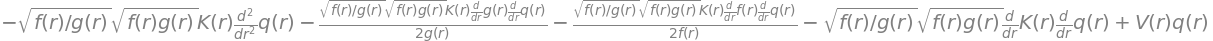

In [11]:
eigen = -sympy.sqrt(f / g) * sympy.diff(sympy.sqrt(f * g) * K * dq, r) + V * q
eigen.expand()

Simplify.

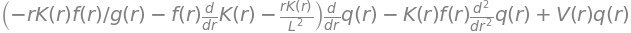

In [12]:
eigen = -r * f * K * dq / g - f * K * ddq - f * dK * dq + V * q - r * K * dq / L ** 2
eigen.collect([q, dq])

Separate the terms.

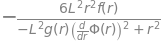

In [13]:
ddq_factor = eigen.coeff(ddq).subs({K: K_sol})
ddq_factor

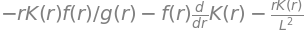

In [14]:
dq_factor = eigen.coeff(dq)
dq_factor

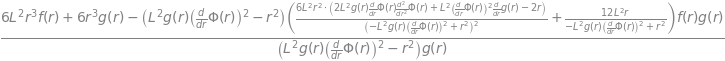

In [15]:
dq_factor = dq_factor.subs({K: K_sol}).simplify()
dq_factor

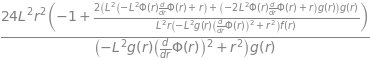

In [16]:
q_factor = eigen.coeff(q).subs({V: V_sol})
q_factor

#### Discretize

The idea is to tune r_0, the length of the wormhole throat, and determine the eigenvalue. Since r_0 = bL, this amounts to tuning b. Therefore, all functions should depend on b.

For numerical convenience, we will make the change of variables r = r_0 * y / (1 - y) = bLy / (1 - y).

First, form a grid.

In [17]:
def cheb(N, x_minus, x_plus):
    def get_a_j(x, j):
        a = 1
        for k in range(len(x)):
            if k != j:
                a *= x[j] - x[k]
        return a

    x = (x_plus + x_minus) / 2 + (x_plus - x_minus) / 2 * np.cos(np.pi * np.arange(0, N + 1) / N)

    D = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        a_i = get_a_j(x, i)
        for j in range(N + 1):
            if j != i:
                # diagonal element
                D[i, i] += 1 / (x[i] - x[j])
                # off diagonal element
                a_j = get_a_j(x, j)
                D[i, j] = a_i / (a_j * (x[i] - x[j]))

    return D, x

In [18]:
y_minus = 0
y_plus = 0.9
N = 50

In [19]:
D, y_vals = cheb(N, y_minus, y_plus)
D

array([[ 1.85222222e+03, -2.25232275e+03,  5.63636791e+02, ...,
         2.23101835e+00, -2.22441691e+00,  1.11111111e+00],
       [ 5.63080686e+02, -2.81262291e+02, -3.75881602e+02, ...,
        -1.11661523e+00,  1.11330797e+00, -5.56104228e-01],
       [-1.40909198e+02,  3.75881602e+02, -7.01757215e+01, ...,
         1.11994219e+00, -1.11661523e+00,  5.57754586e-01],
       ...,
       [-5.57754586e-01,  1.11661523e+00, -1.11994219e+00, ...,
         7.01757215e+01, -3.75881602e+02,  1.40909198e+02],
       [ 5.56104228e-01, -1.11330797e+00,  1.11661523e+00, ...,
         3.75881602e+02,  2.81262291e+02, -5.63080686e+02],
       [-1.11111111e+00,  2.22441691e+00, -2.23101835e+00, ...,
        -5.63636791e+02,  2.25232275e+03, -1.85222222e+03]])

In [20]:
D2 = D @ D
D2

array([[ 2.05761284e+06, -3.27064673e+06,  1.77027475e+06, ...,
         8.25970607e+03, -8.23528084e+03,  4.11358025e+03],
       [ 9.51492710e+05, -1.36104076e+06,  4.94016598e+05, ...,
         6.30617173e+02, -6.28742010e+02,  3.14059306e+02],
       [-5.96447987e+04,  2.29818432e+05, -2.81883946e+05, ...,
        -1.59694044e+02,  1.59212217e+02, -7.95260218e+01],
       ...,
       [-7.95260218e+01,  1.59212217e+02, -1.59694044e+02, ...,
        -2.81883946e+05,  2.29818432e+05, -5.96447987e+04],
       [ 3.14059306e+02, -6.28742010e+02,  6.30617173e+02, ...,
         4.94016598e+05, -1.36104076e+06,  9.51492710e+05],
       [ 4.11358025e+03, -8.23528084e+03,  8.25970607e+03, ...,
         1.77027475e+06, -3.27064673e+06,  2.05761284e+06]])

In [21]:
L_val = 1

In [22]:
def evaluate_factors_numerically(b_val):
    """Evaluate the different factors in the differential equations for a given value of b."""
    ny = len(y_vals)

    ddq_factors_num = np.zeros((ny, ny))
    dq_factors_num = np.zeros((ny, ny))
    q_factors_num = np.zeros((ny, ny), dtype=object)

    r_0_val = b_val * L_val

    for idx, y_val in enumerate(y_vals):
        r_val = r_0_val * y_val / (1 - y_val)

        f_val = f_func(r_val, r_0_val, L_val)
        g_val = g_func(r_val, r_0_val)
        dg_val = dg_func(r_val)
        Phi_val = phi_of_r(r_val, b_val, L_val)
        dPhi_val = dphi_of_r(r_val, b_val, L_val)
        ddPhi_val = ddphi_of_r(r_val, b_val, L_val)

        func_subs = {r: r_val, L: L_val, f: f_val, g: g_val, dg: dg_val, Phi: Phi_val, dPhi: dPhi_val, ddPhi: ddPhi_val}

        ddq_factors_num[idx, idx] = ddq_factor.subs(func_subs)
        dq_factors_num[idx, idx] = dq_factor.subs(func_subs)
        q_factors_num[idx, idx] = q_factor.subs(func_subs)

    return ddq_factors_num, dq_factors_num, q_factors_num

In [23]:
def get_A_matrix(b_val, boundary_condition='qdot'):
    """Build the A matrix of the eigenvalue problem given the value for b.

    Args:
        boundary_condition (str): Can be 'q' or 'qdot'. If 'q', then condition q(0) = 0 is used. If 'qdot', then
            q'(0) = 0

    """
    ddq_factors_num, dq_factors_num, q_factors_num = evaluate_factors_numerically(b_val)
    A = ddq_factors_num @ D2 + dq_factors_num @ D + q_factors_num

    if boundary_condition == 'qdot':
        A[-1] = D[-1]
        A = A.astype(float)
    else:
        A[-1] = 0
        A[-1][-1] = 1
        A = A.astype(float)

    return A

In [24]:
def get_B_matrix():
    """Build the B matrix."""
    B = np.identity(len(y_vals))
    B[-1] = 0
    return B

Get the eigenvalues for the general eigenvalue problem A * p = lam * B * p.

In [25]:
b_0_min = 1.251462

In [26]:
A = get_A_matrix(b_0_min)
B = get_B_matrix()
w, vr = linalg.eig(A, B, homogeneous_eigvals=True)

Validate the eigenvalues.

In [27]:
errors = []
for i in range(len(w)):
    errors.append(np.abs(w[1, i] * A @ vr[:, i] - w[0, i] * B @ vr[:, i]).max())
print("Max error =", max(errors))

Max error = 1.7434358596801758e-06


Plot the eigenvectors.

/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


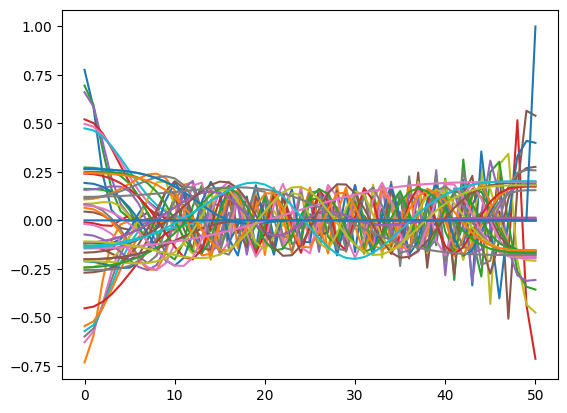

In [28]:
plt.plot(range(w.shape[1]), vr);

Get eigenvalues for different values of b.

In [29]:
def get_eigenvalues(b_val):
    """Get the eigenvalues given the value for b."""
    A = get_A_matrix(b_val)
    B = get_B_matrix()

    eigenvalues = linalg.eigvals(A, B, homogeneous_eigvals=True)[0]
    eigenvalues = np.real(eigenvalues[~np.iscomplex(eigenvalues)])
    eigenvalues.sort()

    return eigenvalues

In [30]:
eigenvalues = []

fracs = [0.9, 0.95, 1, 1.05]

for frac in fracs:
    eigenvalues.append(get_eigenvalues(frac * b_0_min))

Plot the eigenvalues.

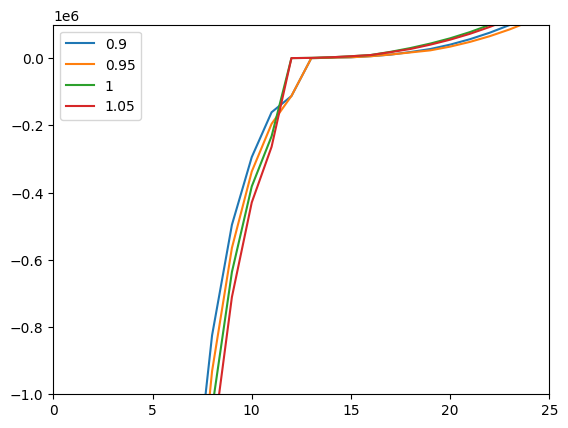

In [31]:
for i in range(len(eigenvalues)):
    plt.plot(range(len(eigenvalues[i])), eigenvalues[i], label=fracs[i])

plt.legend()
plt.xlim([0, 25])
plt.ylim([-1e6, 1e5]);

##### Verify Chebyshev differentiation

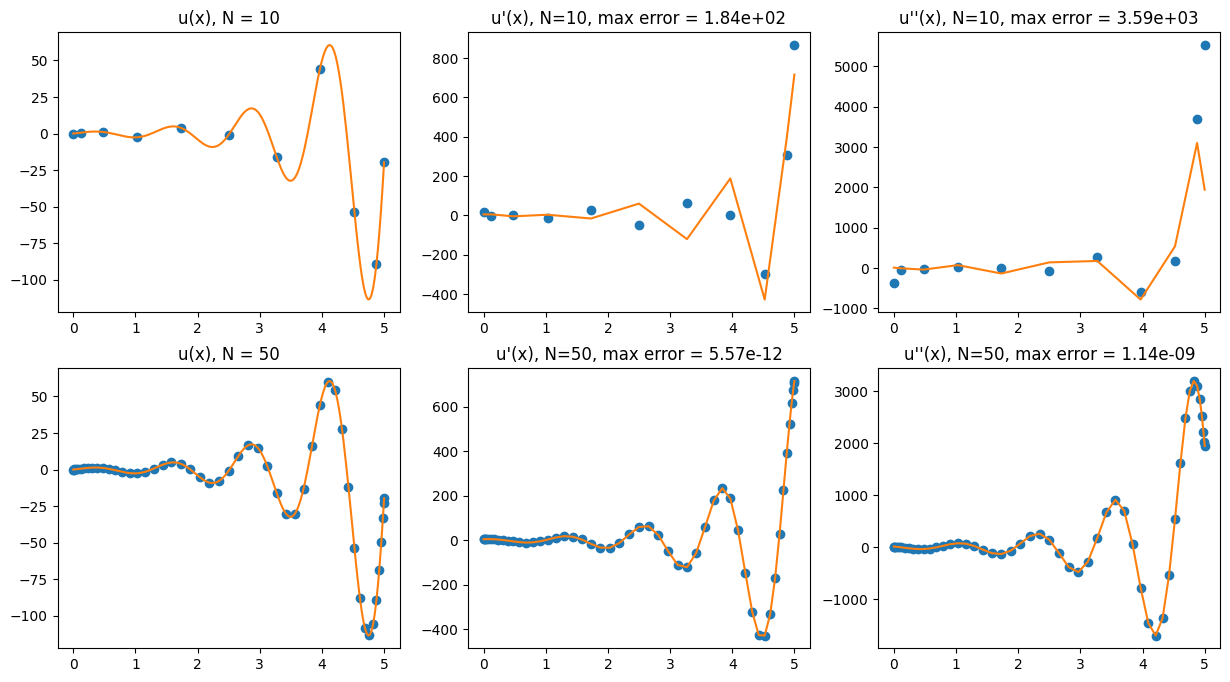

In [32]:
x_min = 0
x_max = 5

xx = np.linspace(x_min, x_max, 200, True)
uu = np.exp(xx) * np.sin(5.0 * xx)

c = 1; plt.figure(figsize=(15, 8))

for N in [10, 50]:
    D, x = cheb(N, x_min, x_max)
    u = np.exp(x) * np.sin(5.0 * x)

    plt.subplot(2, 3, c); c += 1
    plt.plot(x, u, 'o', xx, uu)
    plt.title(f'u(x), N = {N}')

    deriv_est = np.dot(D, u)
    deriv_true = np.exp(x) * (np.sin(5.0 * x) + 5.0 * np.cos(5.0 * x))
    max_error_deriv = np.abs(max(deriv_est - deriv_true))

    plt.subplot(2, 3, c); c += 1
    plt.plot(x, deriv_est, 'o', x, deriv_true)
    plt.title(f'u\'(x), N={N}, max error = {max_error_deriv:.2e}')

    dderiv_est = np.dot(D @ D, u)
    dderiv_true = np.exp(x) * (-24.0 * np.sin(5.0 * x) + 10.0 * np.cos(5.0 * x))
    max_error_dderiv = np.abs(max(dderiv_est - dderiv_true))

    plt.subplot(2, 3, c); c += 1
    plt.plot(x, dderiv_est, 'o', x, dderiv_true)
    plt.title(f'u\'\'(x), N={N}, max error = {max_error_dderiv:.2e}')

/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarni

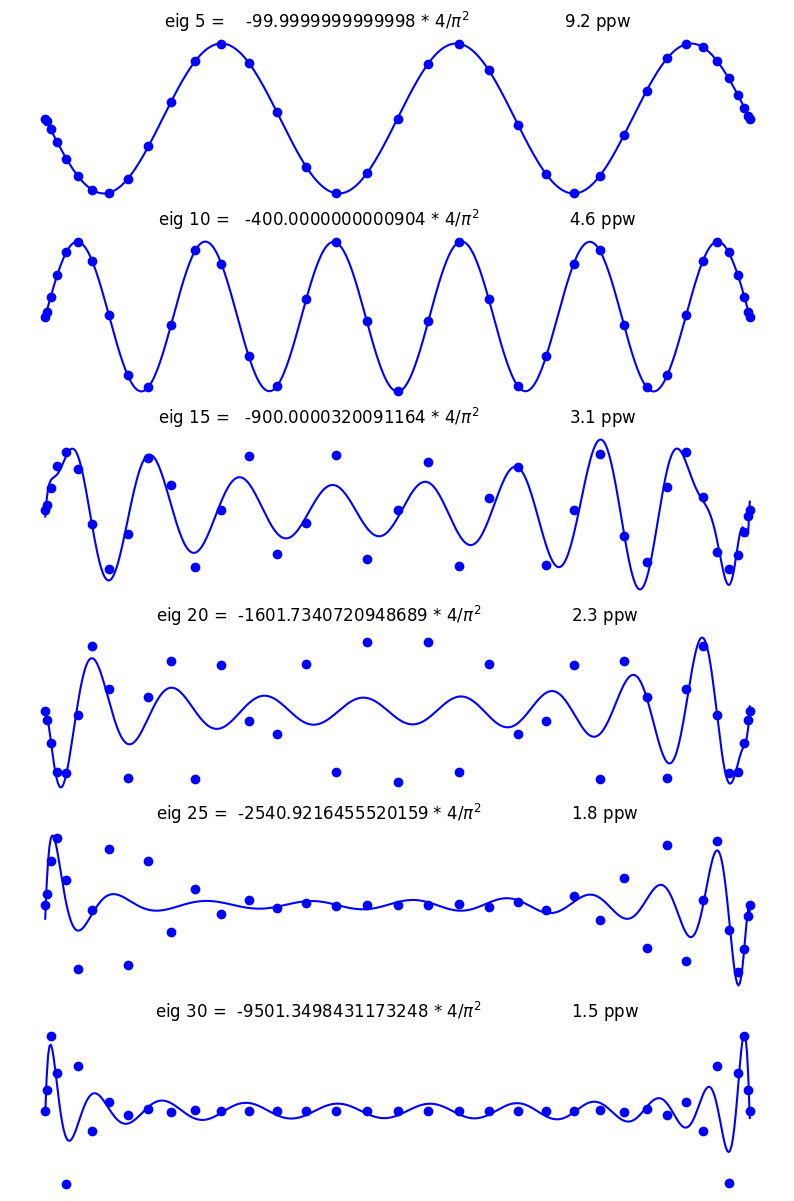

In [33]:
N = 36

x_min = 0
x_max = 1

D, x = cheb(N, x_min, x_max)
D2 = np.dot(D, D)
D2 = D2[1:N, 1:N]

lam, V = linalg.eig(D2)   
ii = np.argsort(-lam)
lam = np.real(lam[ii])
V = V[:, ii]

fig = plt.figure(figsize=(10, 15))
for j in range(5, 35, 5): 
    lv = np.shape(V)[0] + 2
    u = np.zeros(lv)
    u[1:lv - 1] = V[:, int(j)]  

    plt.subplot(6, 1, j//5)
    plt.plot(x, u, 'bo')

    xx = np.linspace(x_min, x_max, 501)
    uu = np.polyval(np.polyfit(x, u, N), xx)    # interpolate grid data
    s = 'eig %d = %20.13f * 4/$\pi^2$' % (j, lam[j-1]*4/np.pi**2)
    s = s + '\t\t %4.1f ppw' % (4*N/(np.pi*j))

    plt.title(s)
    plt.plot(xx,uu,'b')
    plt.axis('off')